#### Rating and Ranking with Massey's and Keener's Methods:

#### The Premier League case

This is the __solution__ notebook.

We will analyse Premier League results for two seasons; Results have been downloaded from [www.footballwebpages.co.uk](https://www.footballwebpages.co.uk/premier-league) for the following seasons:

- [2021-22 season](https://www.footballwebpages.co.uk/premier-league/match-grid/2021-2022);
- [2022-23 season](https://www.footballwebpages.co.uk/premier-league/match-grid/2022-2023);
- [2023-24 season](https://www.footballwebpages.co.uk/premier-league/match-grid/2023-2024), and
- [2024-25 season](https://www.footballwebpages.co.uk/premier-league/match-grid/2024-2025).




### Import the needed Python modules

In [118]:
import requests
import io

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Set pandas and numpy options for printing results

In [119]:
np.set_printoptions(linewidth=1000)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')

### Premier League winners:

*   **2021-22**: Manchester City (1-point gap from Liverpool, who finished second; Arsenal finished 5th)

*   **2022-23**: Manchester City (5-points gap from Arsenal)

*   **2023-24**: Manchester City (2-point gap from Arsenal)

*   **2024-25**: Liverpool (10 points above Arsenal)

In [120]:
N_TEAMS = 20

### Data file URLs from DSTA GitHub repository

In [121]:
DATA_FOLDER_URL = "https://raw.githubusercontent.com/ale66/learn-datascience/main/week-9/Ranking_premier_league/data"

# League table GitHub URLs
league_table_2021_2022 = f"{DATA_FOLDER_URL}/2021_2022_LeagueTable.csv"
league_table_2022_2023 = f"{DATA_FOLDER_URL}/2022_2023_LeagueTable.csv"
league_table_2023_2024 = f"{DATA_FOLDER_URL}/2023_2024_LeagueTable.csv"
league_table_2024_2025 = f"{DATA_FOLDER_URL}/2024_2025_LeagueTable.csv"

# Match grid GitHub URLs
match_grid_2021_2022 = f"{DATA_FOLDER_URL}/2021_2022_MatchGrid.csv"
match_grid_2022_2023 = f"{DATA_FOLDER_URL}/2022_2023_MatchGrid.csv"
match_grid_2023_2024 = f"{DATA_FOLDER_URL}/2023_2024_MatchGrid.csv"
match_grid_2024_2025 = f"{DATA_FOLDER_URL}/2024_2025_MatchGrid.csv"

### Utility functions

In [122]:
def read_league_tbl(url: str) -> pd.DataFrame:
    """
    Read a season league table CSV from a GitHub URL.
    The first row is skipped, as it groups information in
    Home, Away and Total, which is not needed.

    :param url: CSV GitHub URL.
    :return: League table as dataframe.
    """
    response = requests.get(url)
    content = response.content.decode("utf-8")
    league_tbl = pd.read_csv(io.StringIO(content), skiprows=1)

    # Add actual team ranking
    league_tbl["Actual_Ranking"] = np.arange(1, N_TEAMS + 1)
    return league_tbl


def read_match_grid(url: str) -> pd.DataFrame:
    """
    Read a season match grid CSV from a GitHub URL.

    Each match entry is in format ="GH-GA" (except from NaN in diagonal).
    GH are goals scored by the home team, and GA are goals scored
    by the away team. The function reads the match grid CSV,
    removes '=' and '"', and adds "0-0" in the diagonal to remove NaNs.

    :param url: CSV GitHub URL.
    :return: Match grid as dataframe.
    """
    response = requests.get(url)
    content = response.content.decode("utf-8")

    return (
    pd.read_csv(io.StringIO(content), dtype=str, index_col=0)
    .replace('"' , '', regex=True)
    .replace('=' , '', regex=True)
    .fillna("0-0")
    )

### Set current working data files and next season files

Hint: Change these variables in case you would like to rate / rank teams based on a different season and check the estimates against the actual rankings of the following season.

In [123]:
# Current (working) season
current_season = "2023 - 2024"
curr_league_tbl = league_table_2023_2024
curr_match_grid = match_grid_2023_2024

# Next season
coming_season = "2024 - 2025"
next_league_tbl = league_table_2024_2025
next_match_grid = match_grid_2024_2025

### Massey's ratings for the Premiership league table

#### Import the league table of the *current* season

In [ ]:
league_table = read_league_tbl(curr_league_tbl)

league_table

#### Keep columns about goals scored and rename for clarity

In [ ]:
required_cols = ["Unnamed: 1", "P.2", "F", "A", "+/-", "Pts", "Actual_Ranking"]

renaming = {
    "Unnamed: 1": "Teams", 
    "P.2": "Total_Matches_Played", 
    "F": "Goals_Scored",
    "A": "Goals_Conceded",
    "+/-": "Goal_Difference",
    "Pts": "Points"
    }

# Make a copy of the league table, keeping only the necessary columns renamed
league_table = (
    league_table
    .loc[:, required_cols]
    .copy()
    .rename(columns=renaming)
)

league_table

#### Create Massey's $\overline{M}$ and $\overline{p}$

Below is a refresher of Massey's modela.

The exact Linear system $\mathbf{Mr} = \mathbf{p}$ is unviable as the $M$ matrix is surely singular, thus not invertible.

So, let's focus on Massey's modified system:

$\mathbf{\overline{M}r} = \mathbf{\overline{p}}$

Massey Matrix - last row elements set to 1:

$\mathbf{\overline{M}_{n \times n}} = \begin{pmatrix}
  38 & -2 & -2 & \dots & -2\\
  -2 & 38 & -2 & \dots & -2\\
  -2 & -2 & 38 & \dots & -2\\
  \vdots & \vdots & \vdots & \ddots & -2\\
  1 & 1 & 1 & \dots & 1
  \end{pmatrix}$

The *Goal Difference Column Vector:*

$\mathbf{\overline{p}_{n \times 1}} = \begin{pmatrix}
p_1\\
p_2\\
p_3\\
\vdots \\
0
\end{pmatrix}$

So we calculate the ratings Vector:

$\mathbf{r}_{n \times 1} = \begin{pmatrix}
r_1\\
r_2\\
r_3\\
\vdots \\
r_n
\end{pmatrix}$


By solving Massey's system:

$\mathbf{r} = \mathbf{\overline{M}^{-1}} \mathbf{\overline{p}}$

In [126]:
# Matches played per team
MATCHES_PLAYED_PER_TEAM = 2 * (N_TEAMS - 1)

In [127]:
# Create M matrix
# Non-diagonal elements: The negated number of matches between each pair of teams
# Diagonal elements: Total matches played per team (both home and away).
M = -2 * np.ones((N_TEAMS, N_TEAMS))

diagonal = np.ones((1, N_TEAMS)) * MATCHES_PLAYED_PER_TEAM

last_row = np.ones((1, N_TEAMS))

np.fill_diagonal(M, diagonal)

M[-1:] = last_row

# Create p column vector with goal difference. Shape: (N_TEAMS, 1)
p = league_table["Goal_Difference"].to_numpy().reshape((-1, 1))

p[-1] = 0

#### Solve the system and calculate Massey rankings and ratings - use MinMaxScaler for easier plotting of ratings further below

Please see the relative [sklearn MinMaxScaler documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [128]:
# Solve the equation system to calculate ratings and add them to the data
r = np.linalg.inv(M).dot(p)

league_table["Massey_Rating"] = r

# Scale the ratings between the weakest and stronger team actual points.
# MinMaxScaler accepts a tuple (min, max) as input to define the range.
min_max_scaler = MinMaxScaler((league_table.Points.min(), league_table.Points.max()))

league_table["Massey_Scaled_Rating"] = min_max_scaler.fit_transform(
    league_table
        .loc[:, "Massey_Rating"]
        .to_numpy()
        .reshape(-1, 1)
)

# Sort the data by calculated ratings and add Massey ranking
league_table = league_table.sort_values("Massey_Rating", ascending=False)

league_table["Massey_Ranking"] = np.arange(1, N_TEAMS + 1)

#### Keep a copy of the data to compile ratings/rankings from all methods

In [129]:
compiled_results = (
    league_table
    .sort_values("Actual_Ranking", ascending=True)
    .copy()
    )

In [ ]:
# Run this if you would like to check the "compiled_results"
compiled_results

#### Plot Massey's scaled ratings-rankings, side-by-side with actual ranking and points scored

Documentation for [matplotlib.pyplot horizontal bar plots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.barh.html)

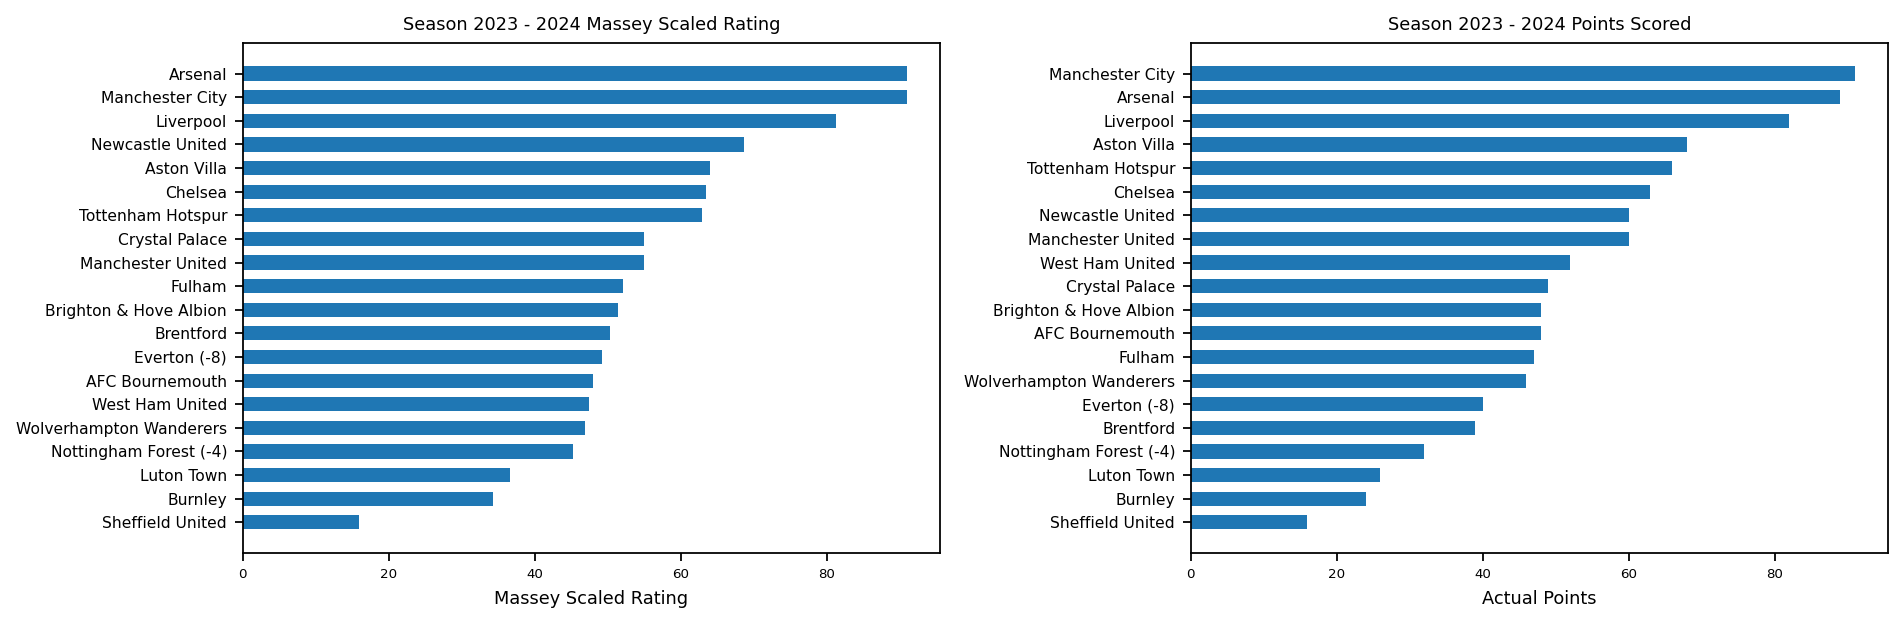

In [131]:
# Initialize grid of plots
_, axis = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=160)

# Plot Massey scaled rating - plot 0, row 0
axis[0].barh(
    league_table["Massey_Ranking"], 
    league_table["Massey_Scaled_Rating"], 
    height=0.6, align='center'
    )

# Configure y axis
axis[0].set_yticks(
    league_table["Massey_Ranking"], 
    labels=league_table["Teams"],
    fontsize=7
    )

axis[0].invert_yaxis()  # labels read top-to-bottom

# X-axis and title
axis[0].tick_params(axis="x", labelsize=6)
axis[0].set_xlabel('Massey Scaled Rating', fontsize=8)
axis[0].set_title(f'Season {current_season} Massey Scaled Rating', fontsize=8)

# Plot actual ranking and points scored - plot 1, row 0
axis[1].barh(
    league_table["Actual_Ranking"], 
    league_table["Points"], 
    height=0.6, align='center'
    )

# Configure y axis
axis[1].set_yticks(
    league_table["Actual_Ranking"], 
    labels=league_table["Teams"],
    fontsize=7
    )

axis[1].invert_yaxis()  # labels read top-to-bottom

# X-axis and title
axis[1].tick_params(axis="x", labelsize=6)
axis[1].set_xlabel('Actual Points', fontsize=8)
axis[1].set_title(f'Season {current_season} Points Scored', fontsize=8)

# Use 'tight_layout' to avoid overlapping text
plt.tight_layout()
plt.show()

### Keener's method

#### For Keener, we need the match grid

In [ ]:
match_grid = read_match_grid(curr_match_grid)

# Save all teams as a list
teams = match_grid.columns.to_list()

match_grid

#### Create Keener's S matrix

Below is a refresher of the method:

$S_{n \times n}$ where $S_{ij}:$ total goals scored by team $i$ against team $j$; here *n* represents the total number of teams in the league.

#### Exercise 1: Complete the code to calculate Keener's S matrix

#### Step-by-step:

1.   Parse scores. Example: "3-2". The home team scored 3 goals and the away team 2. 
   
   Hint: Pandas [applymap documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.applymap.html)
   
2.   Match every team's home match with the respective away match against the same opponent. 
   
   Hint: The home match of team *i* against *j* is element *ij*. The respective away match is element *ji* - row and column indexes are swapped...

In [ ]:
# Parse score and get goals of a home match
home_goals_ij = lambda score: int(score.split("-")[0])

all_home_goals_ij = match_grid.applymap(home_goals_ij)

# Parse score and get goals of an away match
# The grid is transposed to match every team's respective
# home and away matches
away_goals_ij = lambda score: int(score.split("-")[1])

all_away_goals_ij = match_grid.T.applymap(away_goals_ij)

# Sum goals scored
S_dataframe = all_home_goals_ij + all_away_goals_ij

In [ ]:
S_dataframe

#### Create Keener's A matrix

Below is a refresher

$\mathbf{A}_{n \times n} = \left[\frac{S_{ij}+ 1}{S_{ij} + S_{ji} + 2}\right]_{n \times n}$
<br>
<br>
$\mathbf{A}_{n \times n} = [a_{ij}] = \left[h\left(\frac{S_{ij}+ 1}{S_{ij} + S_{ji} + 2}\right)\right]_{n \times n}$
<br>
<br>
$\text{where } h(x) = \frac{1}{2} + \frac{sgn\{x - (1/2)\}\sqrt{|2x - 1|}}{2}$

#### Exercise 2: Complete the code (check 'TODO' comments) to get matrix A

#### Calculate the Numerator

In [ ]:
A_numerator = S_dataframe.copy().to_numpy() + 1

A_numerator

#### Calculate the Denominator

In [136]:
A_denominator = S_dataframe.copy().to_numpy()

A_denominator += A_denominator.T

A_denominator += 2

#### Calculate A

In [137]:
A = np.divide(A_numerator, A_denominator)

#### Apply skewing to A

Please see the Numpy [vectorize documentation](https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html) and [Generalized Universal Function API documentation](https://numpy.org/doc/stable/reference/c-api/generalized-ufuncs.html).

In [138]:
def skewing_function(x: float) -> float:
    """
    Function proposed by Keener to skew the data of
    matrix A calculated above.

    :parameter x: A single entry of matrix A.
    :return: The transformed entry passed through the skewing function
    """
    numerator = np.sign(x - 0.5) * np.sqrt(np.abs(2 * x - 1))
    return 0.5 + numerator / 2

# Vectorize the skewing function to apply it on a numpy array
ufunc_skewing_function = np.vectorize(skewing_function)
A = ufunc_skewing_function(A)

# Uncomment if you want to inspect the final A matrix
# A

#### Calculate Eigenvalues and Eigenvectors

Numpy [documentation on eigenvalues and eigenvectors](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html)

$\mathbf{A} \mathbf{r} = λ \mathbf{r}, \mathbf{r} > 0 \text{ and } \sum_{j=1}^{n}r_j = 1$


$\lambda:$ Perron's value (the *dominant* eigenvalue)

$\mathbf{r:}$ Perron vector (dominant eigenvector)


Looking for the Ratings Vector:

$\\\mathbf{r}_{n \times 1} = \begin{pmatrix}
r_1\\
r_2\\
r_3\\
\vdots \\
r_n
\end{pmatrix}$

#### Exercise 3: Compute eigenvalues and eigenvectors of A and pick the largest eigenvalue

In [139]:
eigenvals, eigenvecs = np.linalg.eig(A)

max_eigenvalue_index = np.argmax(eigenvals)

#### A crucial condition: the dominant eigenvalue must be a real number: its imaginary part must be 0.

In [ ]:
eigenvals[max_eigenvalue_index]

#### Save the Perron value as a float

In [ ]:
perron_value = float(eigenvals[max_eigenvalue_index])

print(f"Perron value: {perron_value}")

#### The dominant eigenvector must be real: all entries must have imaginary part 0.

In [ ]:
eigenvecs[: , max_eigenvalue_index].reshape(-1, 1)

#### Save the real part of the dominant eigenvector entries

This is not the Perron vector yet (we could get all entries as negatives). 

We use the *Brute Force* technique described in Keener chapter of the textbook to convert this vector into a Perron vector.

In [ ]:
dominant_eigenvector = eigenvecs[: , 0].reshape(-1, 1).astype(float)

dominant_eigenvector

#### Normalise the actual Perron vector so that ratings sum to 1

In [144]:
# Divide by sum so that all ratings sum to 1
perron_vector = dominant_eigenvector / np.sum(dominant_eigenvector)

In [145]:
match_grid["Keener_Rating"] = perron_vector

In [ ]:
match_grid["Keener_Rating"]

#### Use a MinMaxScaler to scale Keener ratings for plotting.

In [148]:
# Scale the ratings between the weakest and stronger team actual points.
# MinMaxScaler accepts a tuple (min, max) as input to define the range.
min_max_scaler = MinMaxScaler((league_table.Points.min(), league_table.Points.max()))

match_grid["Keener_Scaled_Rating"] = min_max_scaler.fit_transform(
    match_grid
        .loc[:, "Keener_Rating"]
        .values
        .reshape(-1, 1)
    )

# Sort by Keener rating (the strongest team on top), add Keener ranking
match_grid = match_grid.sort_values("Keener_Rating", ascending=False)
match_grid["Keener_Ranking"] = np.arange(1, N_TEAMS + 1)

In [ ]:
match_grid

#### Import the league table to get actual rankings and points scored

As the match grid does not contain the actual points scored per team, we have to import the league table.

In [ ]:
league_table = read_league_tbl(curr_league_tbl)

league_table

#### We keep only teams, actual ranking and points.

In [ ]:
required_cols = ["Unnamed: 1", "Pts", "Actual_Ranking"]

renaming = {"Unnamed: 1": "Teams", "Pts": "Points"}

# Make a copy of the league table, keeping only the necessary columns renamed
# Index is reset as the teams for the table join below
league_table = (
    league_table
    .loc[:, required_cols]
    .copy()
    .rename(columns=renaming)
    .set_index("Teams")
)

league_table

In [152]:
# Tidy-up team names
league_table.index = league_table.index.str.replace(r"\s\(-\d{1,}\)", "", regex=True)

#### Join the match grid that holds Keener ratings with the league table and the actual ratings based on team names

In [ ]:
match_grid = match_grid.join(league_table)

match_grid

#### Add Keener to the dataset that holds results from Massey

In [ ]:
cols_to_keep = [
    "Keener_Rating", 
    "Keener_Scaled_Rating", 
    "Keener_Ranking"
    ]

# Data needed from Keener output - sort by actual ranking first
data_to_keep = (
    match_grid
    .sort_values("Actual_Ranking", ascending=True)
    .loc[:, cols_to_keep]
    .copy()
    .reset_index(drop=False)
    .rename(columns={"index": "Teams"})
    )

# Again, team name tidy-up is needed
compiled_results["Teams"] = compiled_results["Teams"].str.replace(r"\s\(-\d{1,}\)", "", regex=True)
compiled_results = compiled_results.merge(data_to_keep, on="Teams")

compiled_results

#### Plot Keener's scaled rating and ranking side by side with actual ranking and points scored

In [ ]:
# Initialize grid of plots
_, axis = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=160)

# Plot Keener scaled rating - plot 0, row 0
axis[0].barh(
    match_grid["Keener_Ranking"], 
    match_grid["Keener_Scaled_Rating"], 
    height=0.6, align='center'
    )

# Configure y axis
axis[0].set_yticks(
    match_grid["Keener_Ranking"], 
    labels=match_grid.index,
    fontsize=7
    )

axis[0].invert_yaxis()  # labels read top-to-bottom

# X-axis and title
axis[0].tick_params(axis="x", labelsize=6)
axis[0].set_xlabel('Keener Scaled Rating', fontsize=8)
axis[0].set_title(f'Season {current_season} Keener Scaled Rating', fontsize=8)

# Plot actual ranking and point scored - plot 1, row 0
axis[1].barh(
    match_grid["Actual_Ranking"], 
    match_grid["Points"], 
    height=0.6, align='center'
    )

# Configure y axis
axis[1].set_yticks(
    match_grid["Actual_Ranking"], 
    labels=match_grid.index,
    fontsize=7
    )

axis[1].invert_yaxis()  # labels read top-to-bottom

# X-axis and title
axis[1].tick_params(axis="x", labelsize=6)
axis[1].set_xlabel('Actual Points', fontsize=8)
axis[1].set_title(f'Season {current_season} Points Scored', fontsize=8)

# Use 'tight_layout' to avoid overlapping text
plt.tight_layout()
plt.show()

### Export merged results from all methods as CSV

In [156]:
# Columns to save
rating_cols = [
    "Teams",
    "Points",
    "Actual_Ranking",
    "Massey_Rating",
    "Massey_Scaled_Rating",
    "Massey_Ranking",
    "Keener_Rating",
    "Keener_Scaled_Rating",
    "Keener_Ranking"
    ]

# Change file name accordingly if you are analyzing a different season
merged_results_csv = "./data/2023_2024_MergedResults.csv"
compiled_results.loc[:, rating_cols].set_index("Teams").to_csv(merged_results_csv, index=True)

### Get rankings from all methods in a new table

In [ ]:
rankings = [
    "Teams",
    "Actual_Ranking",
    "Massey_Ranking",
    "Keener_Ranking"
    ]

ranks_df = compiled_results.loc[:, rankings].copy().set_index("Teams")
ranks_df

#### Check correlation between ranking methods to check how the match with the actual ranking

In [ ]:
ranks_df.corr()

#### Import the table of the subsequent season to check

In [159]:
next_league_table = read_league_tbl(next_league_tbl)

# Uncomment if you want to see the raw table
# next_league_table

#### Keep necessary columns and rename them

In [ ]:
required_cols = ["Unnamed: 1", "P.2", "W.2", "D.2", "L.2", "F", "A", "+/-", "Pts", "Actual_Ranking"]

renaming = {
    "Unnamed: 1": "Teams",
    "P.2": "Total_Matches_Played",
    "W.2": "Total_Wins",
    "D.2": "Total_Draws",
    "L.2": "Total_Losses",
    "F": "Goals_Scored",
    "A": "Goals_Conceded",
    "+/-": "Goal_Difference",
    "Pts": "Points"
    }

# Make a copy of the league table, keeping only the necessary columns renamed
next_league_table = (
    next_league_table
    .loc[:, required_cols]
    .copy()
    .rename(columns=renaming)
)

next_league_table

#### Recall estimated rankings from Massey and Keener

In [ ]:
ranks_df